In [6]:
%load_ext autoreload
%autoreload 2
from lab.postprocessing.toolbox import *
from lab.postprocessing.visualization import *
from lab.data.datasets import SpiralDataset
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
import torch
import os
import numpy as np

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
result_dir = '/home/iai/user/conrads/rnn-cnn/results'

In [8]:
def plot_data(dataset, n_samples=int(1e4)):
    input = dataset.input[:n_samples]
    target = dataset.target[:n_samples]
    class1 = input[target == 0]
    class2 = input[target == 1]

    plt.scatter(class1[:, 0], class1[:, 1], c='darkred', s=1, label='class 1')
    plt.scatter(class2[:, 0], class2[:, 1], c='midnightblue', s=1, label='class 2')
    plt.legend()
    plt.xlim(-58, 58)
    plt.ylim(-55, 55)
    plt.xticks([])
    plt.yticks([])

# custom colormap
cw = cm.get_cmap('coolwarm', 1000)
CMAP = ListedColormap(cw(np.linspace(0, 1, 1000)[300:700]))

# points to evaluate
POINTS = get_grid_points(-58, 58, -55, 55, step_size=.5)

def plot_decision(logits):
    y = torch.argmax(logits, dim=-1)

    plt.figure(figsize=(6.5, 5), dpi=150)

    y = torch.nn.functional.softmax(logits, dim=1)[:, 0]
    plt.scatter(POINTS[:, 0], POINTS[:, 1], c=y.cpu(), s=10, cmap=CMAP)
    cbar = plt.colorbar()
    cbar.set_label('probability of class 1')
    
def plot_recs(final_steps):
    plt.figure(figsize=(5, 5), dpi=150)
    cmap = plt.get_cmap('tab20c')
    for n_rec in range(max(final_steps+1)):
        plt.scatter(POINTS[:, 0][final_steps == n_rec],
                    POINTS[:, 1][final_steps == n_rec],
                    color=cmap(n_rec), s=10, label=f'{n_rec+1} recurrence')


# Data

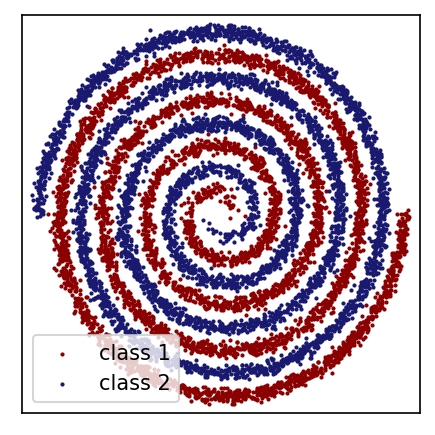

In [9]:
dataset = SpiralDataset(device='cpu', seed=1)
plt.figure(figsize=(3, 3), dpi=150)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/spiral'))

In [50]:
acc_mlp = []
model_dir = 'spiral/mlp/_model_layer_dims_(5, 5)'
acc_mlp.append(load_and_evaluate_dir(result_dir, model_dir))

model_dir = 'spiral/mlp/_model_layer_dims_(5, 5, 5)'
acc_mlp.append(load_and_evaluate_dir(result_dir, model_dir))

model_dir = 'spiral/mlp/_model_layer_dims_(5, 5, 5, 5)'
acc_mlp.append(load_and_evaluate_dir(result_dir, model_dir))


accuracy:  66.38 +-  2.68
cross entropy:  0.520 +-  0.036
number parameters: 57
accuracy:  78.07 +-  8.47
cross entropy:  0.365 +-  0.094
number parameters: 87
accuracy:  90.81 +-  4.99
cross entropy:  0.187 +-  0.095
number parameters: 117


In [71]:
acc_thresh = []
model_dir = 'spiral/rnn/_model_max_rec_2_model_stopping_criterion_threshold'
acc_thresh.append(load_and_evaluate_dir(result_dir, model_dir))

model_dir = 'spiral/rnn/_model_max_rec_3_model_rnn_type_linear_model_stopping_criterion_threshold'
acc_thresh.append(load_and_evaluate_dir(result_dir, model_dir))

model_dir = 'spiral/rnn/_model_max_rec_2_model_rnn_type_myrnn1_model_stopping_criterion_threshold'
acc_thresh.append(load_and_evaluate_dir(result_dir, model_dir))





accuracy:  66.89 +-  3.77
cross entropy:  0.525 +-  0.056
average steps:  1.738 +-  0.124
number parameters: 57
accuracy:  70.13 +-  4.29
cross entropy:  0.491 +-  0.041
average steps:  2.278 +-  0.139
number parameters: 57
accuracy:  77.83 +-  7.98
cross entropy:  0.381 +-  0.087
average steps:  1.621 +-  0.120
number parameters: 137


In [101]:
crit_estim = sklearn.tree.DecisionTreeClassifier(max_depth=15)
acc_estim = []
model_dir = 'spiral/rnn/_model_max_rec_2_model_stopping_criterion_first_correct'
acc_estim.append(load_and_evaluate_dir(result_dir, model_dir, crit_estim))

model_dir = 'spiral/rnn/_model_max_rec_3_model_rnn_type_linear_model_stopping_criterion_first_correct'
acc_estim.append(load_and_evaluate_dir(result_dir, model_dir, crit_estim))

model_dir = 'spiral/rnn/_model_max_rec_2_model_rnn_type_myrnn1_model_stopping_criterion_first_correct'
acc_estim.append(load_and_evaluate_dir(result_dir, model_dir, crit_estim))

model_dir = 'spiral/rnn/_model_max_rec_3_model_rnn_type_myrnn1_model_stopping_criterion_first_correct'
acc_estim.append(load_and_evaluate_dir(result_dir, model_dir, crit_estim))


accuracy:  78.37 +-  0.83
cross entropy:  95.374 +-  69.158
average steps:  1.509 +-  0.186
number parameters: 57
accuracy:  78.30 +-  1.06
cross entropy:  141.755 +-  112.229
average steps:  1.587 +-  0.089
number parameters: 57
accuracy:  88.03 +-  4.69
cross entropy:  7.062 +-  5.006
average steps:  1.347 +-  0.086
number parameters: 137
accuracy:  93.36 +-  7.81
cross entropy:  7.637 +-  5.684
average steps:  1.274 +-  0.043
number parameters: 137


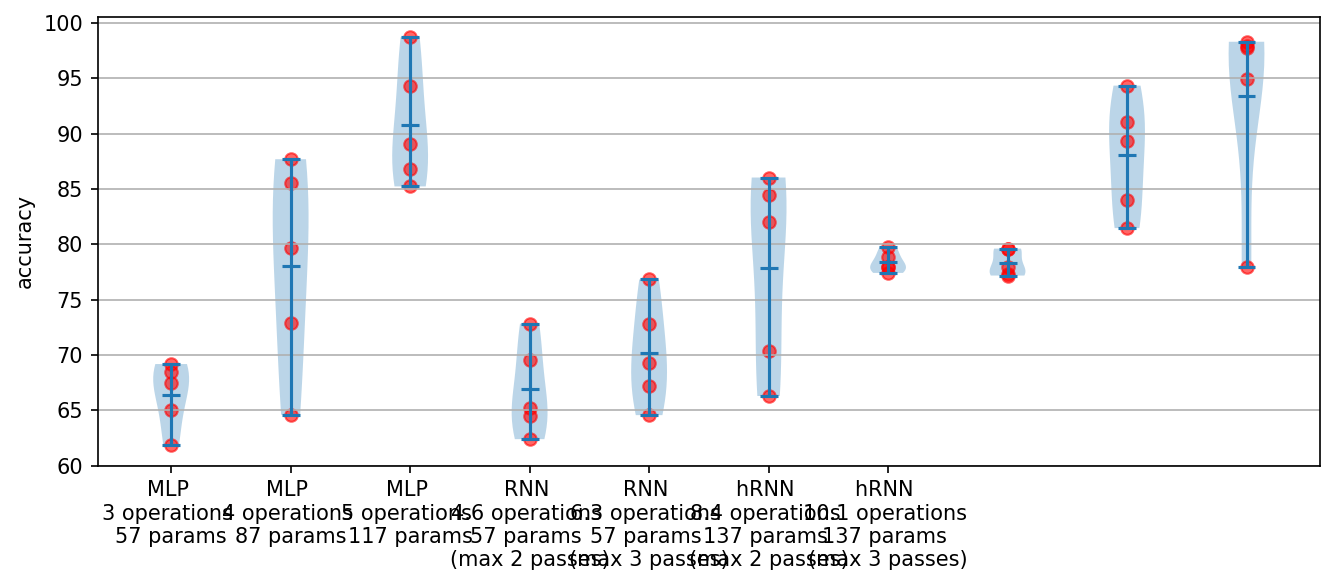

In [102]:
plt.figure(figsize=(9, 4), dpi=150)

make_violin_plot(acc_mlp + acc_thresh + acc_estim)

plt.xticks(range(7), ['MLP \n3 operations \n57 params',
                      'MLP \n4 operations \n87 params', 
                      'MLP \n5 operations \n117 params', 
                      'RNN \n4.6 operations \n57 params \n(max 2 passes)', 
                      'RNN \n6.3 operations \n57 params \n(max 3 passes)', 
                      'hRNN \n8.4 operations \n137 params \n(max 2 passes)',
                      'hRNN \n10.1 operations \n137 params \n(max 3 passes)'])
plt.ylabel('accuracy')
plt.tight_layout()
plt.grid(visible=True, axis='y')
plt.savefig(os.path.join(result_dir, 'images/spiral_violin_ext'))

# MLP

model layers:
Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=2, bias=True)
)


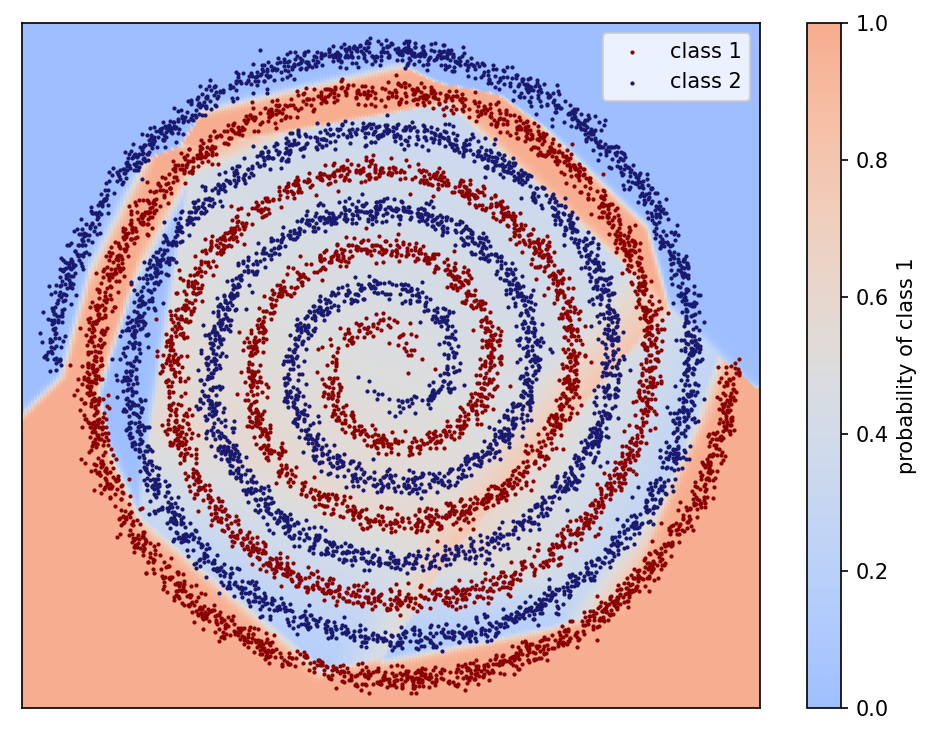

In [5]:
model_name = 'spiral/mlp_cv/_model_layer_dims_(5, 5)/0607-115504'

model, loader = load_model(result_dir, model_name)

# evaluate model for all points in the plane
logits = model(POINTS.to(model.device))
plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/spiral_mlp3'))
model.print_layers()

# MLP 4 layers

model layers:
Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=5, out_features=5, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=5, out_features=5, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=5, out_features=2, bias=True)
)


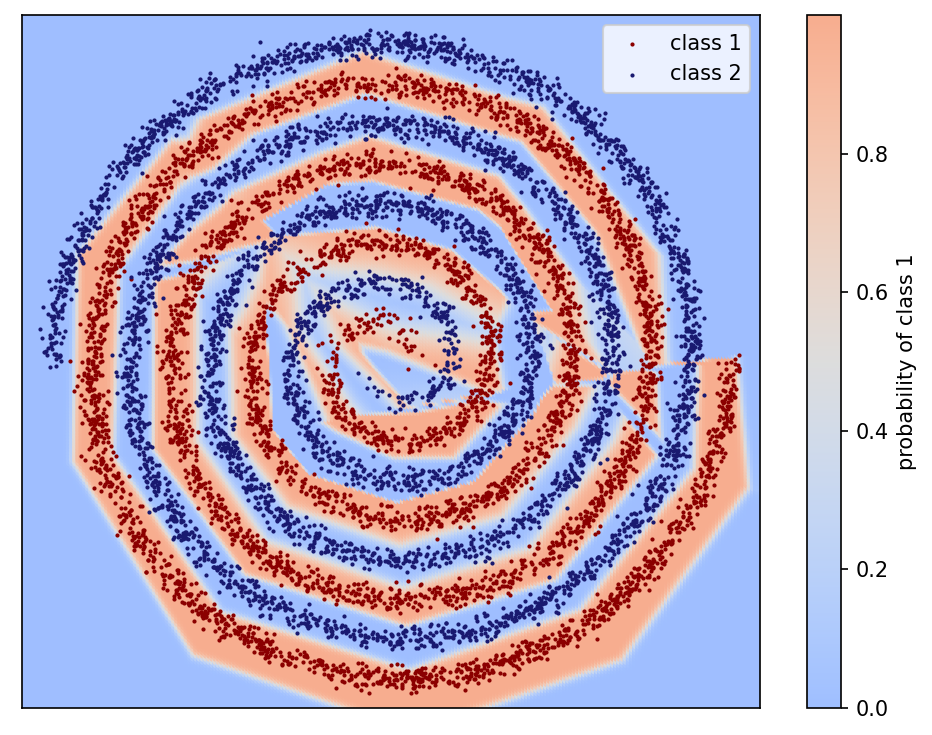

In [6]:
model_name = 'spiral/mlp_cv/_model_layer_dims_(5, 5, 5)/0602-121514'

model, loader = load_model(result_dir, model_name)

# evaluate model for all points in the plane
logits = model(POINTS.to(model.device))
plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
plt.savefig(os.path.join(result_dir, 'images/spiral_mlp4'))
model.print_layers()

# RNN


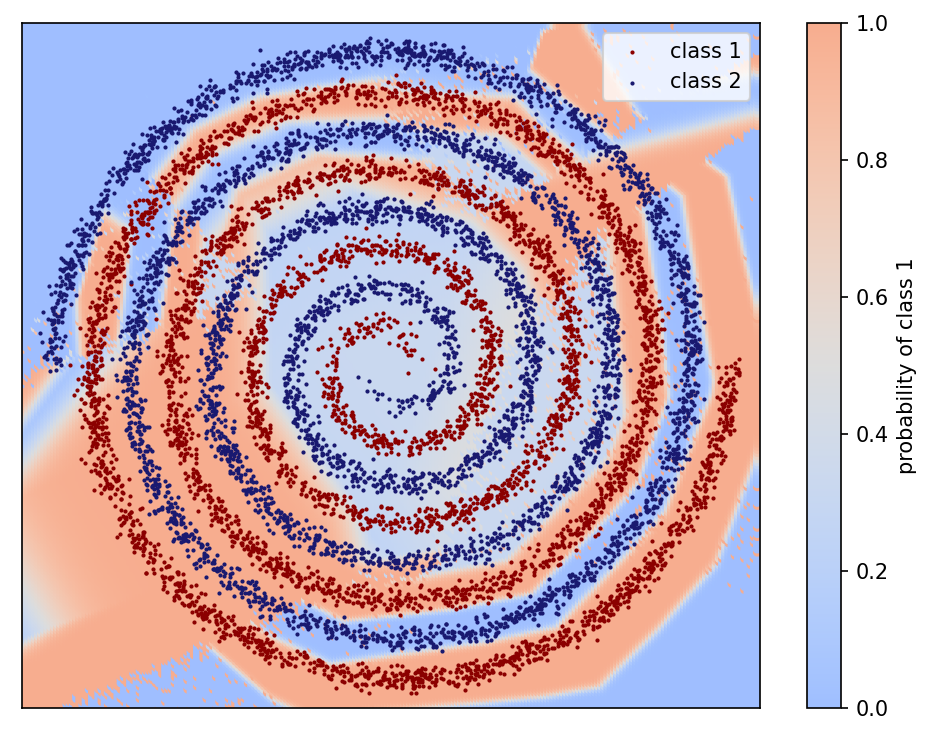

In [12]:
model_name = 'spiral/rnn_fn/_model_rnn_type_linear_model_reg_target_0.8_model_rec_fn_layers_(5,)_model_rec_fn_input_embedding/0714-132355'

model, _ = load_model(result_dir, model_name)

logits_stacked, final_steps, _ = model(POINTS.to(model.device))
if final_steps.dim() == 2:
    final_steps = torch.argmax(final_steps, dim=-1)
logits = model.get_final_logits(logits_stacked, final_steps)

plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
#plt.savefig(os.path.join(result_dir, 'images/spiral_rnn_dec'))

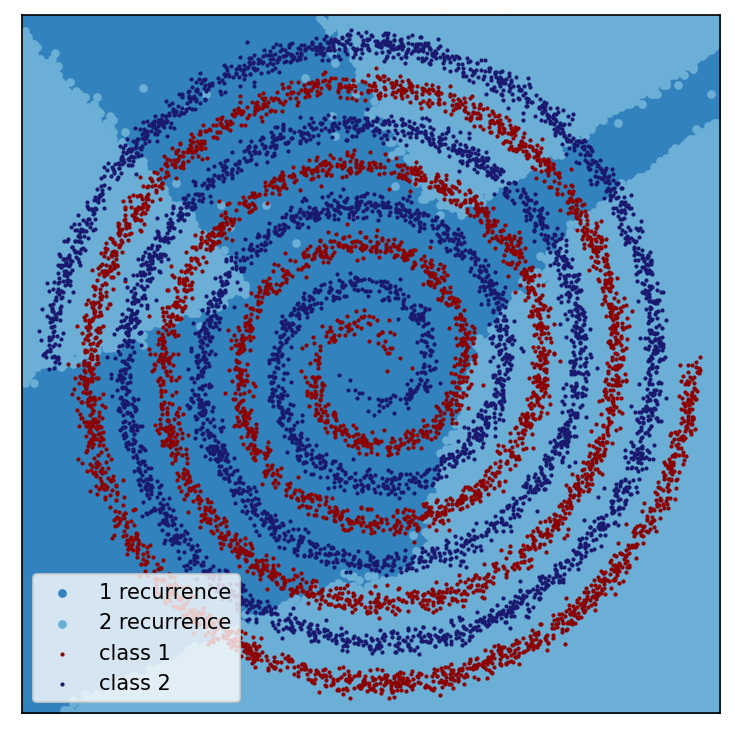

In [13]:
plot_recs(final_steps)
plot_data(dataset)
plt.tight_layout()
#plt.savefig(os.path.join(result_dir, 'images/spiral_rnn_rec'))

training estimator
testing estimator
recurrence estimator test accuracy: 0.86695
model accuracy: 87.21500411629677
model steps: 1.1490000009536743


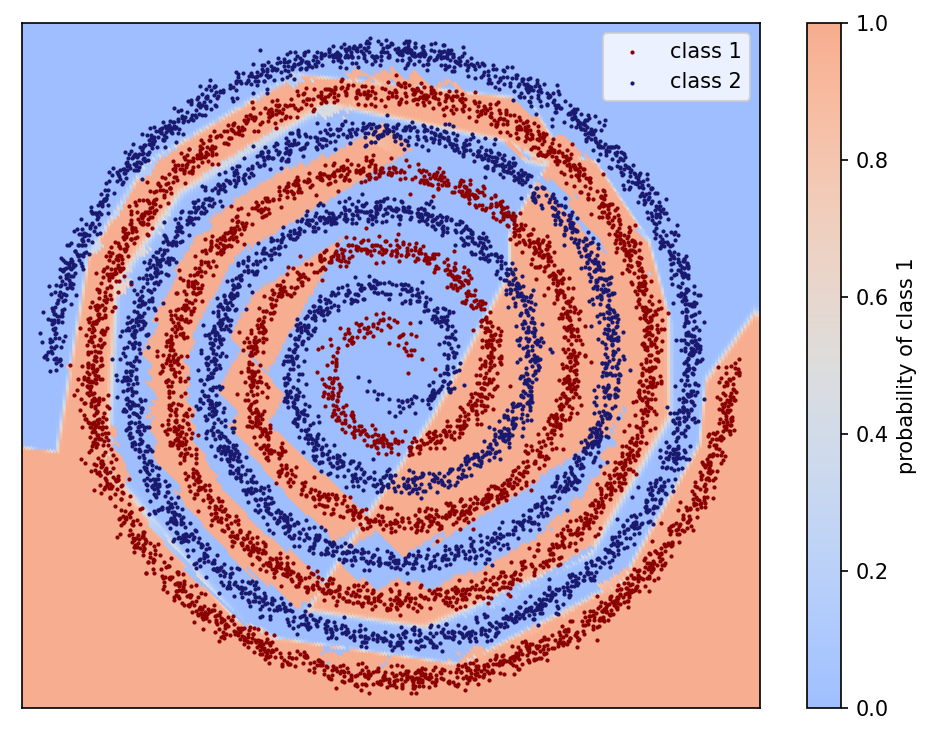

In [89]:
result_dir = '/home/iai/user/conrads/rnn-cnn/results'
model_name = 'spiral/rnn/_model_max_rec_2_model_rnn_type_myrnn1_model_stopping_criterion_first_correct/0731-144136'

model, loader = load_model(result_dir, model_name)
model.use_embedding = False

crit_estim = sklearn.tree.DecisionTreeClassifier(max_depth=15)
crit_estim = get_recurrence_estimator(model, loader, crit_estim, verbose=True)
model.crit_estim = crit_estim

acc, _, steps = evaluate(model, loader.valid)
print('model accuracy:', acc)
print('model steps:', steps)

logits_stacked = model(POINTS.to(model.device))
final_steps = model.get_final_steps(POINTS.to(model.device), logits_stacked, None, evaluate=True)
#final_steps = torch.ones_like(final_steps, device=model.device)
logits = model.get_final_logits(logits_stacked, final_steps)

plot_decision(logits)
plot_data(dataset)
plt.tight_layout()
#plt.savefig(os.path.join(result_dir, 'images/blobmod_rnn_dec'))

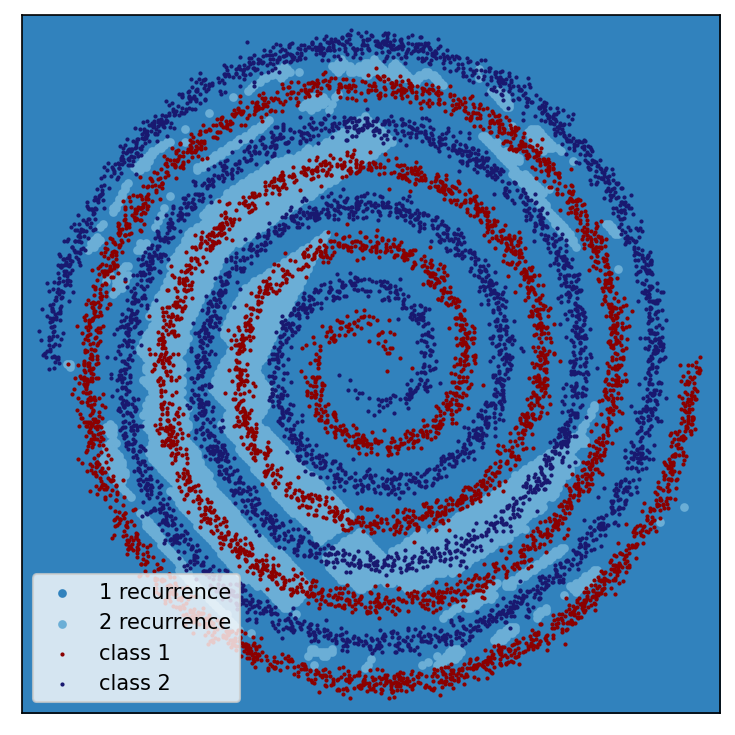

In [90]:
plot_recs(final_steps)
plot_data(dataset)
plt.tight_layout()
#plt.savefig(os.path.join(result_dir, 'images/blob_rnn_rec'))

tensor([0.9111, 0.0889], device='cuda:0')
tensor(5.1779, device='cuda:0')


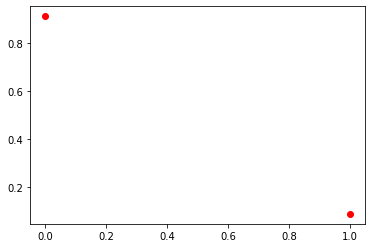

In [80]:
#model_name = 'spiral/rnn/sched50_model_max_rec_3/0614-134637'
#model_name = 'spiral/myrnn/_model_hidden_dim_5_model_max_rec_3_model_fixed_input_True_model_rnn_type_myrnn/0613-101514'
#model, loader = load_model(result_dir, model_name)
hgram = make_histogram_plot(model, loader)
print(hgram)
avg_rec = 3
for i, frac in enumerate(hgram):
    avg_rec += (i + 1) * 2 * frac
print(avg_rec)

In [5]:
model_dir = 'spiral/mlp_cv/_model_layer_dims_(5, 5)'
acc_mlp3 = load_and_evaluate_dir_cv(result_dir, model_dir)

accuracy:  70.19 +-  7.76
cross entropy:  0.472 +-  0.108
number parameters: 57


In [6]:
model_dir = 'spiral/mlp_cv/_model_layer_dims_(5, 5, 5)'
acc_mlp4 = load_and_evaluate_dir_cv(result_dir, model_dir)

accuracy:  86.12 +-  6.56
cross entropy:  0.245 +-  0.093
number parameters: 87


In [7]:
model_dir = 'spiral/mlp_cv/_model_layer_dims_(5, 5, 5, 5)'
acc_mlp5 = load_and_evaluate_dir_cv(result_dir, model_dir)

accuracy:  90.22 +-  6.56
cross entropy:  0.172 +-  0.108
number parameters: 117


In [8]:
model_dir = 'spiral/rnn_cv_sched50/'
acc_rnn2 = load_and_evaluate_dir_cv(result_dir, model_dir)

accuracy:  76.09 +-  6.45
cross entropy:  0.423 +-  0.078
average steps:  1.813 +-  0.075
number parameters: 57


In [10]:
model_dir = 'spiral/rnn/sched50_model_max_rec_3'
acc_rnn3 = load_and_evaluate_dir(result_dir, model_dir)

accuracy:  68.20 +-  9.94
cross entropy:  0.469 +-  0.088
average steps:  2.427 +-  0.180
number parameters: 57


In [11]:
model_dir = 'spiral/myrnn/_model_hidden_dim_5_model_max_rec_2_model_fixed_input_True_model_rnn_type_myrnn'
acc_hrnn2 = load_and_evaluate_dir(result_dir, model_dir)

accuracy:  92.69 +-  3.68
cross entropy:  0.170 +-  0.059
average steps:  1.814 +-  0.079
number parameters: 137


In [12]:
model_dir = 'spiral/myrnn/_model_hidden_dim_5_model_max_rec_3_model_fixed_input_True_model_rnn_type_myrnn'
acc_hrnn3 = load_and_evaluate_dir(result_dir, model_dir)

accuracy:  94.97 +-  4.33
cross entropy:  0.119 +-  0.075
average steps:  2.443 +-  0.256
number parameters: 137


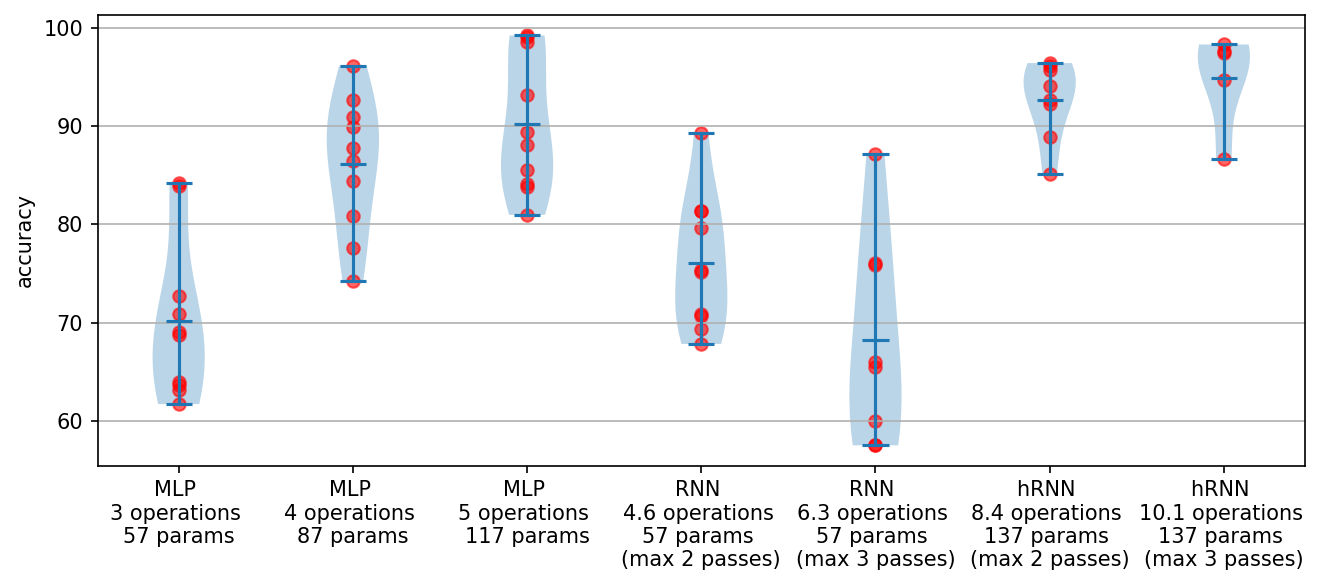

In [28]:
plt.figure(figsize=(9, 4), dpi=150)

make_violin_plot([acc_mlp3, acc_mlp4, acc_mlp5, acc_rnn2, acc_rnn3, acc_hrnn2, acc_hrnn3])

plt.xticks(range(7), ['MLP \n3 operations \n57 params',
                      'MLP \n4 operations \n87 params', 
                      'MLP \n5 operations \n117 params', 
                      'RNN \n4.6 operations \n57 params \n(max 2 passes)', 
                      'RNN \n6.3 operations \n57 params \n(max 3 passes)', 
                      'hRNN \n8.4 operations \n137 params \n(max 2 passes)',
                      'hRNN \n10.1 operations \n137 params \n(max 3 passes)'])
plt.ylabel('accuracy')
plt.tight_layout()
plt.grid(visible=True, axis='y')
plt.savefig(os.path.join(result_dir, 'images/spiral_violin_ext'))

In [56]:
import scipy
scipy.stats.ttest_ind(acc_mlp, acc_rnn, equal_var=False)

NameError: name 'acc_mlp' is not defined